In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data_preprocessed/df_preprocessed.csv', parse_dates=['Date'])

In [3]:
#Let's just focus on 1 day target
df = df.drop(columns = ['Target_1week', 'Target_1month', 'Target_1year'])
df["Target_1day"] = df["Close"].pct_change(1).shift(-1) * 100  
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,reddit_Comment1_Sentiment_negative,reddit_Comment1_Sentiment_neutral,reddit_Comment1_Sentiment_positive,reddit_Comment2_Sentiment_negative,reddit_Comment2_Sentiment_neutral,reddit_Comment2_Sentiment_positive,reddit_Comment3_Sentiment_negative,reddit_Comment3_Sentiment_neutral,reddit_Comment3_Sentiment_positive,Target_1day
0,2021-09-30,140.983639,141.690227,138.647974,138.863876,89056700,0.0,0.0,23921.991,4.7,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.812750
1,2021-10-01,139.256465,140.257467,136.518448,139.992493,94639600,0.0,0.0,24777.038,4.5,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-2.460568
2,2021-10-04,139.119068,139.560697,135.694095,136.547882,98322000,0.0,0.0,24777.038,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.415843
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630698
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908468


In [4]:
# Feature Engineering
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_lag5'] = df['Close'].shift(5)
df['Close_rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()

df['Volume_lag1'] = df['Volume'].shift(1)
df['Volume_lag3'] = df['Volume'].shift(3)
df['Volume_lag5'] = df['Volume'].shift(5)
df['Volume_rolling_mean_3'] = df['Volume'].rolling(window=3).mean()
df['Volume_rolling_mean_7'] = df['Volume'].rolling(window=7).mean()

df['articles_sentiment_Positive_lag1'] = df['articles_sentiment_Positive'].shift(1)
df['articles_sentiment_Positive_lag3'] = df['articles_sentiment_Positive'].shift(3)
df['articles_sentiment_Positive_lag5'] = df['articles_sentiment_Positive'].shift(5)
df['articles_sentiment_Positive_rolling_mean_3'] = df['articles_sentiment_Positive'].rolling(window=3).mean()
df['articles_sentiment_Positive_rolling_mean_7'] = df['articles_sentiment_Positive'].rolling(window=7).mean()

df['Producer Price Index (PPI)_lag1'] = df['Producer Price Index (PPI)'].shift(1)
df['Producer Price Index (PPI)_lag3'] = df['Producer Price Index (PPI)'].shift(3)
df['Producer Price Index (PPI)_lag5'] = df['Producer Price Index (PPI)'].shift(5)
df['Producer Price Index (PPI)_rolling_mean_3'] = df['Producer Price Index (PPI)'].rolling(window=3).mean()
df['Producer Price Index (PPI)_rolling_mean_7'] = df['Producer Price Index (PPI)'].rolling(window=7).mean()

df['reddit_Title_Sentiment_negative_lag1'] = df['reddit_Title_Sentiment_negative'].shift(1)
df['reddit_Title_Sentiment_negative_lag3'] = df['reddit_Title_Sentiment_negative'].shift(3)
df['reddit_Title_Sentiment_negative_lag5'] = df['reddit_Title_Sentiment_negative'].shift(5)
df['reddit_Title_Sentiment_negative_rolling_mean_3'] = df['reddit_Title_Sentiment_negative'].rolling(window=3).mean()
df['reddit_Title_Sentiment_negative_rolling_mean_7'] = df['reddit_Title_Sentiment_negative'].rolling(window=7).mean()

df["return_1d"] = df["Close"].pct_change() * 100
df["volume_change"] = df["Volume"].pct_change() * 100

df.dropna(inplace = True)

In [5]:
# correlations = df.corr(numeric_only=True)["Target_1day"].abs().sort_values(ascending=False)

# # 가장 높은 상위 31개를 추출 (자기 자신 포함 → Target_1day 빼줘야 함)
# top_corr_features = correlations.head(30).index.tolist()
# df =  pd.concat([df[top_corr_features], df["Date"]], axis=1)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,Producer Price Index (PPI)_lag5,Producer Price Index (PPI)_rolling_mean_3,Producer Price Index (PPI)_rolling_mean_7,reddit_Title_Sentiment_negative_lag1,reddit_Title_Sentiment_negative_lag3,reddit_Title_Sentiment_negative_lag5,reddit_Title_Sentiment_negative_rolling_mean_3,reddit_Title_Sentiment_negative_rolling_mean_7,return_1d,volume_change
6,2021-10-08,141.346808,141.494007,139.904192,140.237854,58773200,0.0,0.0,24777.038,4.5,...,240.465,240.465,239.781143,0.0,0.0,0.0,0.000000,0.142857,-0.272166,-4.794056
7,2021-10-11,139.619557,142.112231,139.168120,140.149490,64452200,0.0,0.0,24777.038,4.5,...,240.465,240.465,240.465000,0.0,0.0,0.0,0.000000,0.000000,-0.063010,9.662567
8,2021-10-12,140.561661,140.581293,138.412458,138.873703,73035900,0.0,0.0,24777.038,4.5,...,240.465,240.465,240.465000,0.0,0.0,0.0,0.000000,0.000000,-0.910305,13.317932
9,2021-10-13,138.608766,138.765774,136.606762,138.284912,78762700,0.0,0.0,24777.038,4.5,...,240.465,240.465,240.465000,0.0,0.0,0.0,0.000000,0.000000,-0.423976,7.841075
10,2021-10-14,139.462547,141.199577,138.873719,141.081802,69907100,0.0,0.0,24777.038,4.5,...,240.465,240.465,240.465000,0.0,0.0,0.0,0.000000,0.000000,2.022556,-11.243393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,2024-12-23,254.490204,255.369227,253.171646,254.989655,40858800,0.0,0.0,29700.580,4.1,...,253.590,253.590,253.590000,0.0,0.0,0.0,0.333333,0.142857,0.306496,-72.298236
813,2024-12-24,255.209412,257.926411,255.009620,257.916443,23234700,0.0,0.0,29700.580,4.1,...,253.590,253.590,253.590000,1.0,0.0,0.0,0.333333,0.142857,1.147807,-43.134160
814,2024-12-26,257.906429,259.814335,257.347047,258.735504,27237100,0.0,0.0,29700.580,4.1,...,253.590,253.590,253.590000,0.0,0.0,0.0,0.333333,0.142857,0.317568,17.225959
815,2024-12-27,257.546826,258.415896,252.782075,255.309296,42355300,0.0,0.0,29700.580,4.1,...,253.590,253.590,253.590000,0.0,1.0,0.0,0.000000,0.142857,-1.324213,55.505909


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
import torch

# 시간 순 정렬
df = df.sort_values("Date")

# 시간 인덱스 숫자로 변환
df["time_idx"] = (df["Date"] - df["Date"].min()).dt.days

# 시계열 ID (단일 종목이라면 그냥 고정값 사용)
df["series_id"] = "stock_series"

target = "Target_1day"

# 예시로 범주형이 없는 경우
categorical_vars = ["series_id"]
continuous_vars = [col for col in df.columns if col not in ["Date", target] + categorical_vars]

# 최대 시계열 길이 설정 (예: 30일 히스토리, 1일 예측)
max_encoder_length = 30
max_prediction_length = 1

training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["series_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["series_id"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[target] + continuous_vars,
    target_normalizer=GroupNormalizer(groups=["series_id"]),  # <-- 이 줄이 핵심!
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.3,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

logger = TensorBoardLogger("lightning_logs", name="tft_model")

trainer = Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    logger=logger  # 명시적 로거 사용
)


trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
)

raw_predictions, x = tft.predict(train_dataloader, mode="raw", return_x=True)

/Users/wonminkim/Projects/DATCapstone/clean_tft_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wonminkim/Projects/DATCapstone/clean_tft_env/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/wonminkim/Projects/DATCapstone/clean_tft_env/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (mps), used: 

Epoch 1:   0%|          | 0/7 [00:00<?, ?it/s, loss=1.44, v_num=11, train_loss_step=1.600, train_loss_epoch=1.440]        

/Users/wonminkim/Projects/DATCapstone/clean_tft_env/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 29: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.722, v_num=11, train_loss_step=0.787, train_loss_epoch=0.726]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.722, v_num=11, train_loss_step=0.787, train_loss_epoch=0.726]


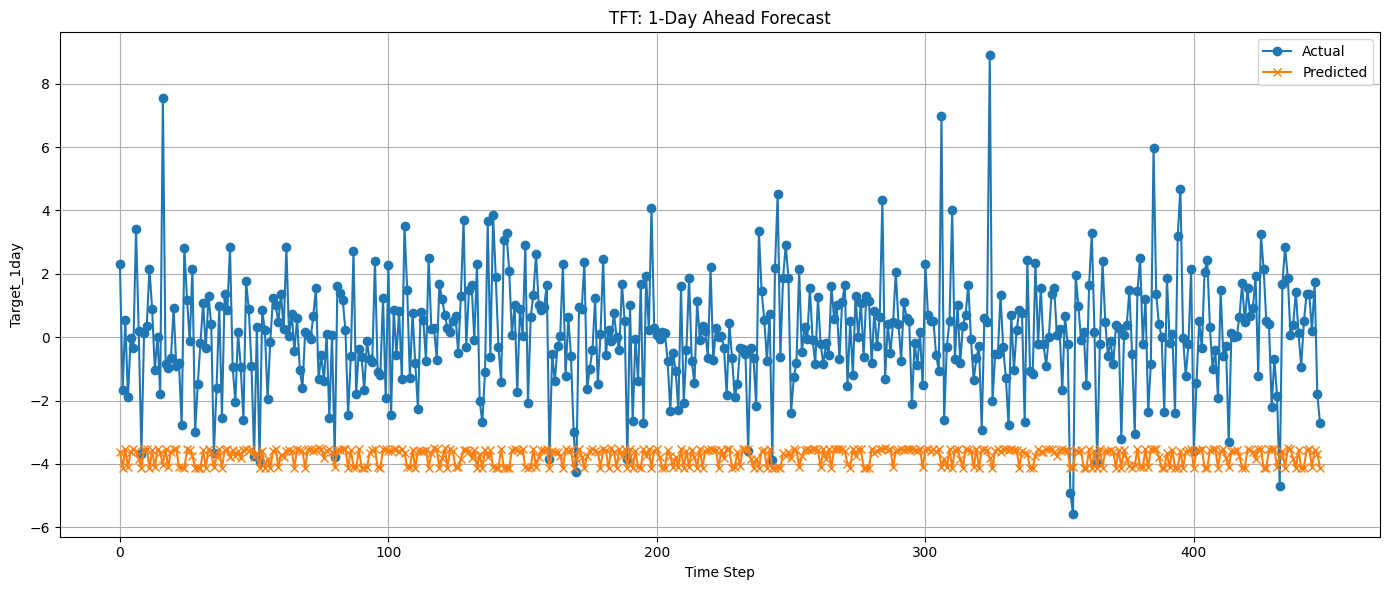

In [11]:
import matplotlib.pyplot as plt
import torch

# 실제값과 예측값
actuals = torch.cat([t for t in x["decoder_target"]], dim=0).detach().cpu().numpy()
predictions = torch.cat([t[:, 0] for t in raw_predictions["prediction"]], dim=0).detach().cpu().numpy()

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(actuals, label="Actual", marker='o')
plt.plot(predictions, label="Predicted", marker='x')
plt.title("TFT: 1-Day Ahead Forecast")
plt.xlabel("Time Step")
plt.ylabel("Target_1day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print(df["Target_1day"].describe())

count    811.000000
mean       0.085724
std        1.696584
min       -5.867966
25%       -0.811625
50%        0.115682
75%        1.009088
max        8.897466
Name: Target_1day, dtype: float64


<Axes: xlabel='Target_1day', ylabel='Count'>

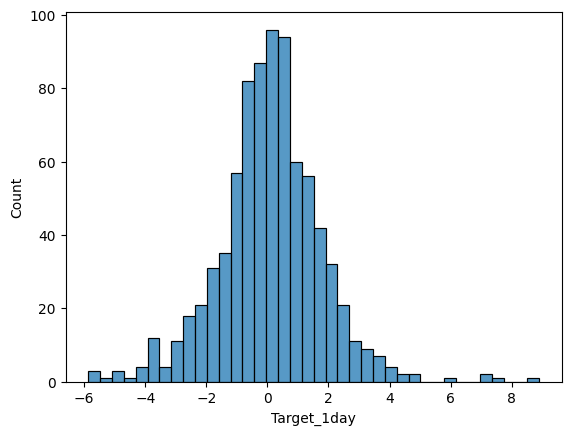

In [13]:
sns.histplot(df['Target_1day'])

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x5975 with 1 Axes>,
 'decoder_variables': <Figure size 700x250 with 1 Axes>}

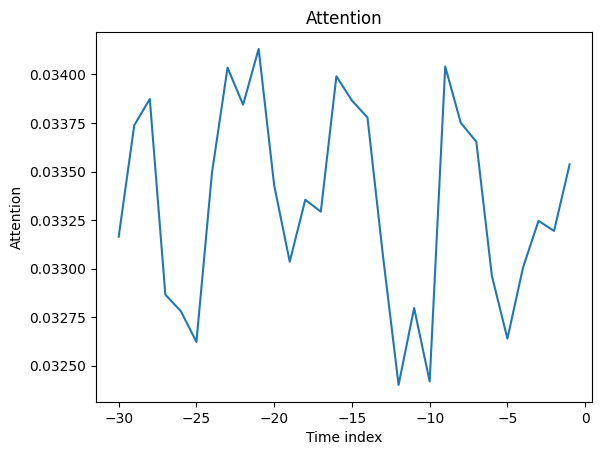

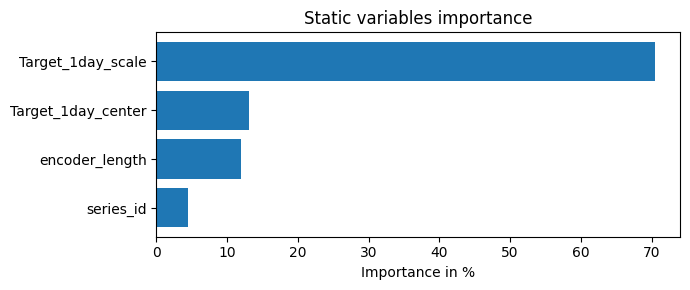

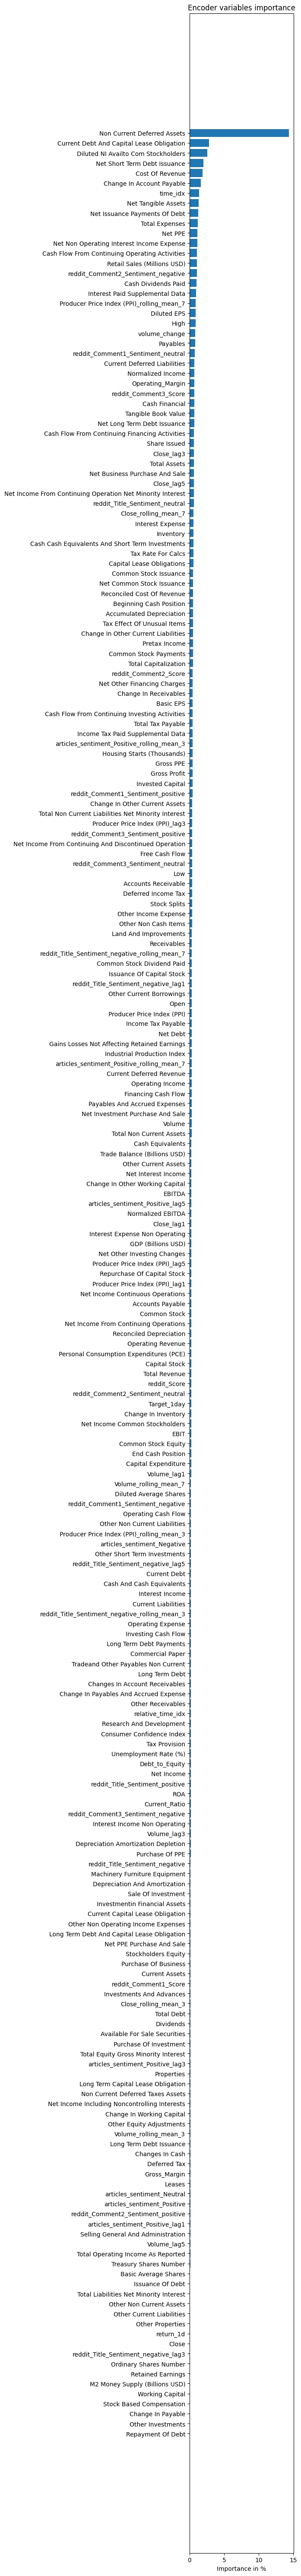

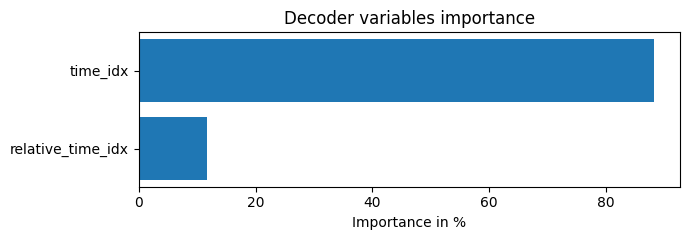

In [14]:
interpretation = tft.interpret_output(raw_predictions, reduction="sum")

tft.plot_interpretation(interpretation)